<a href="https://colab.research.google.com/github/hellosmallkat/Learning-Activity-Neural-Networks-DSP-461/blob/main/boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📘 Assignment: Understanding and Implementing AdaBoost



In this notebook, you will:

1. Use AdaBoost with a built-in library to understand how it works.
2. Implement AdaBoost step-by-step from scratch using PyTorch.
3. Compare the results between the library implementation and your manual one.
4. Reflect on how reweighting and combining weak learners improves performance.



❗❗❗

There is starting code in the cells - check it for errors and correct it as needed. Check for errors in each line of code - it is not guaranteed to be correct.

For each error you find, write a description and correction.

❗❗❗



In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 🧩 Step 1: Load and Explore the Dataset

We'll use the **Breast Cancer Wisconsin** dataset — a public dataset with 30 features and binary labels (malignant vs. benign).


In [3]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target  # 0 = malignant, 1 = benign

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", data.target_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preview data
pd.DataFrame(X_train[:5], columns=data.feature_names).head()


Features shape: (569, 30)
Labels shape: (569,)
Classes: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
1,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
2,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
3,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
4,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


## ⚙️ Step 2: AdaBoost Using a Library

Let's start by using the built-in `AdaBoostClassifier` to see how AdaBoost performs with a simple weak learner.

We'll use a **decision stump** (a tree of depth 1) as the weak classifier.

In [4]:
# Use a decision stump as base learner
base_learner = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_learner, n_estimators=10, random_state=42)

# Train
ada.fit(X_train, y_train)

# Evaluate
y_pred = ada.predict(X_test)
print("Library AdaBoost Accuracy:", accuracy_score(y_test, y_pred))


Library AdaBoost Accuracy: 0.9649122807017544


## 🧮 Step 3: Implementing AdaBoost From Scratch (PyTorch Version)

Now you'll build AdaBoost manually to understand:
- How sample weights are updated,
- How weak learners contribute to the final model,
- How the ensemble improves over time.


In [5]:
# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_train_t = 2 * y_train_t - 1  # convert {0,1} → {-1,+1}

n_samples = X_train_t.shape[0]

# Initialize sample weights equally
w = torch.ones(n_samples) / n_samples

print("Initial weight sum:", w.sum().item())


Initial weight sum: 1.0


## 📜 Step 4: AdaBoost Pseudocode

We'll implement AdaBoost following this algorithm:

For t = 1 to T:
1. Train weak classifier h_t using sample weights w_t
2. Compute predictions y_pred_t
3. Compute weighted error: error_t = Σ_i ( w_i * [y_pred_t != y_i] )
4. Compute model weight: α_t = 0.5 * log((1 - error_t) / error_t)
5. Update weights:
w_i ← w_i * exp(-α_t * y_i * y_pred_t)
Normalize w so Σ_i w_i = 1
Final prediction:
sign( Σ_t α_t * h_t(x) )

Fill in the missing lines in steps 4 and 5.

In [6]:
T = 12  # number of boosting rounds
learners = []
alphas = []

for t in range(T):
    # 1️⃣ Train weak learner
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    # 2️⃣ Predict on training data
    y_pred = stump.predict(X_train)
    y_pred_t = torch.tensor(2*y_pred - 1, dtype=torch.float32)  # convert to {-1,+1}

    # 3️⃣ Compute weighted error
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float()).item()

    # 4️⃣ Compute alpha_t

    alpha_t = 0.5 * torch.log(torch.tensor((1 - error_t) / (error_t + 1e-10))) # did this

    # 5️⃣ Update weights
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t) # did this
    w = w / torch.sum(w)  # normalize weights

    learners.append(stump)
    alphas.append(alpha_t)

    print(f"Round {t+1}: error={error_t:.4f}, alpha={alpha_t:.4f}")


Round 1: error=0.0769, alpha=1.2425
Round 2: error=0.1488, alpha=0.8720
Round 3: error=0.1410, alpha=0.9036
Round 4: error=0.2167, alpha=0.6425
Round 5: error=0.2731, alpha=0.4894
Round 6: error=0.2050, alpha=0.6776
Round 7: error=0.2374, alpha=0.5835
Round 8: error=0.2515, alpha=0.5453
Round 9: error=0.2706, alpha=0.4958
Round 10: error=0.2889, alpha=0.4505
Round 11: error=0.2887, alpha=0.4509
Round 12: error=0.2719, alpha=0.4925


The code I added for step 4 computes the alpha_t by using the 1/2​log(errort​1−errort​​) formula, and step 5 I added wi​⋅e−αt​yi​ht​(xi​) to solve for the updated weight.

## 🧾 Step 5: Evaluate Manual AdaBoost

Now we'll use the weak learners and their α values to make final predictions.

Final prediction rule:
$$
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t \cdot h_t(x) \right)
$$

In [7]:
# Predict using the ensemble
H = torch.zeros(len(X_test))

for alpha_t, stump in zip(alphas, learners):
    y_pred = stump.predict(X_test) # did this
    # uses the
    y_pred = torch.tensor(2*y_pred - 1, dtype=torch.float32)
    H += alpha_t * y_pred

# Final prediction
y_final = torch.sign(H)
y_final[y_final == -1] = 0  # back to {0,1}

manual_acc = (y_final.numpy() == y_test).mean()
print("Manual AdaBoost Accuracy:", manual_acc)


Manual AdaBoost Accuracy: 0.9649122807017544


In [8]:
print("Library AdaBoost Accuracy:", accuracy_score(y_test, ada.predict(X_test)))
print("Manual AdaBoost Accuracy:", manual_acc)


Library AdaBoost Accuracy: 0.9649122807017544
Manual AdaBoost Accuracy: 0.9649122807017544


The part I added was the stump. predict (X_test), which uses the trained weak learner to make predictions on the test set.



## 🧪 Extending Knowledge

Try each following experiments, and discuss the results with two different classmates for each. Write a 1-2 sentence summary of your discussion.

1. Change `T` (number of rounds) to 5, 50 then 100.
2. Try `max_depth=2` for a stronger weak learner.
3. Visualize the evolution of `error_t` and `alpha_t` across rounds by plotting.
4. Plot sample weights to see how AdaBoost focuses on harder examples.


T=5, Manual AdaBoost Accuracy: 0.9298


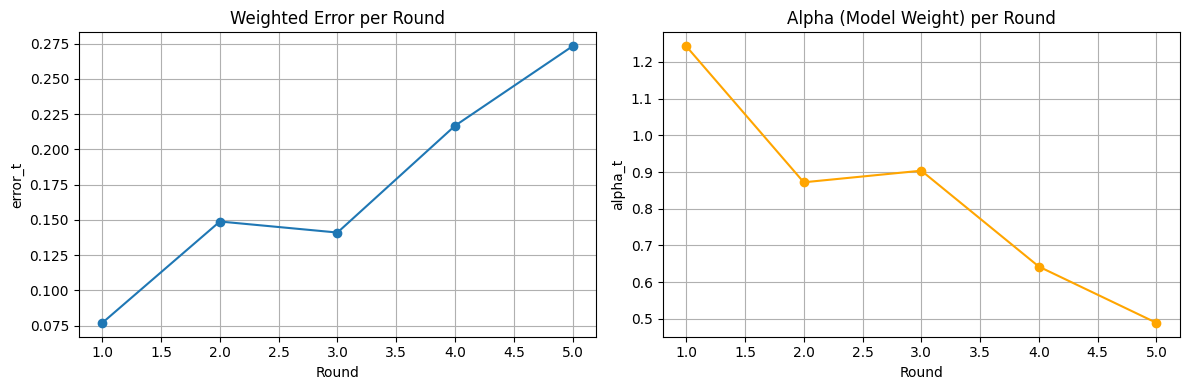

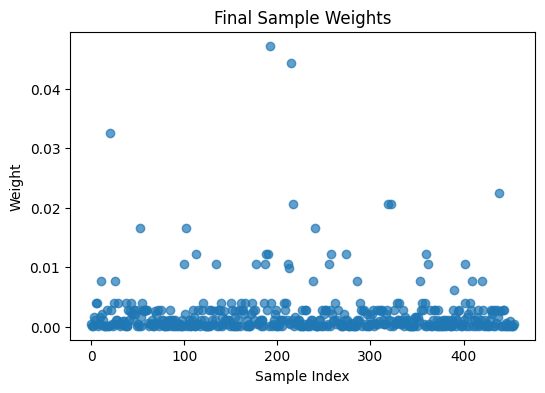

In [9]:
T = 5
learners = []
alphas = []
errors = []
weights_history = []

w = torch.ones(len(X_train), dtype=torch.float32) / len(X_train)

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    y_pred_t = torch.tensor(2*stump.predict(X_train) - 1, dtype=torch.float32)
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float()).item()
    alpha_t = 0.5 * torch.log(torch.tensor((1 - error_t + 1e-10) / (error_t + 1e-10)))
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)

    # ✅ Store for visualization
    errors.append(error_t)
    weights_history.append(w.clone().numpy())

    learners.append(stump)
    alphas.append(alpha_t)

H = torch.zeros(len(X_test))
for alpha_t, stump in zip(alphas, learners):
    y_pred = torch.tensor(2*stump.predict(X_test)-1, dtype=torch.float32)
    H += alpha_t * y_pred
y_final = torch.sign(H)
y_final[y_final==-1] = 0
acc = (y_final.numpy() == y_test).mean()
print(f"T={T}, Manual AdaBoost Accuracy: {acc:.4f}")
plt.figure(figsize=(12,4))

# Weighted error
plt.subplot(1,2,1)
plt.plot(range(1,T+1), errors, marker='o')
plt.title('Weighted Error per Round')
plt.xlabel('Round')
plt.ylabel('error_t')
plt.grid(True)

# Alpha values
plt.subplot(1,2,2)
plt.plot(range(1,T+1), [a.item() for a in alphas], marker='o', color='orange')
plt.title('Alpha (Model Weight) per Round')
plt.xlabel('Round')
plt.ylabel('alpha_t')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot final sample weights
final_weights = weights_history[-1]
plt.figure(figsize=(6,4))
plt.scatter(range(len(final_weights)), final_weights, alpha=0.7)
plt.title('Final Sample Weights')
plt.xlabel('Sample Index')
plt.ylabel('Weight')
plt.show()


T=50, Manual AdaBoost Accuracy: 0.95614035


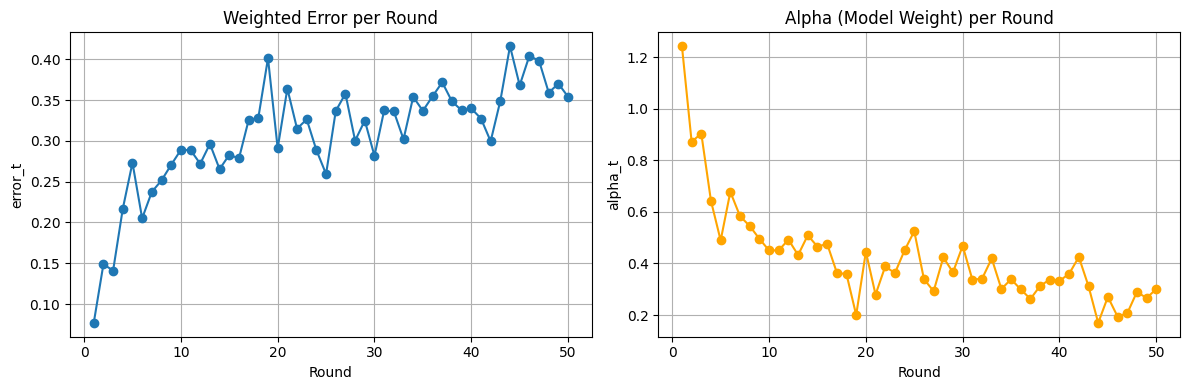

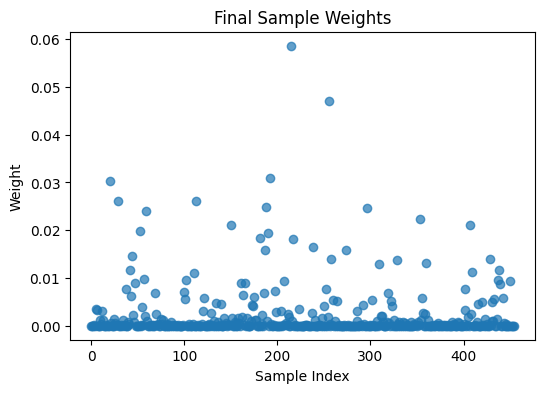

In [10]:
T = 50
learners = []
alphas = []
errors = []
weights_history = []

w = torch.ones(len(X_train), dtype=torch.float32) / len(X_train)

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    y_pred_t = torch.tensor(2*stump.predict(X_train) - 1, dtype=torch.float32)
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float()).item()
    alpha_t = 0.5 * torch.log(torch.tensor((1 - error_t + 1e-10) / (error_t + 1e-10)))
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)

    # ✅ Store for visualization
    errors.append(error_t)
    weights_history.append(w.clone().numpy())

    learners.append(stump)
    alphas.append(alpha_t)

H = torch.zeros(len(X_test))
for alpha_t, stump in zip(alphas, learners):
    y_pred = torch.tensor(2*stump.predict(X_test)-1, dtype=torch.float32)
    H += alpha_t * y_pred
y_final = torch.sign(H)
y_final[y_final==-1] = 0
acc = (y_final.numpy() == y_test).mean()
print(f"T={T}, Manual AdaBoost Accuracy: {acc:.8f}")
plt.figure(figsize=(12,4))

# Weighted error
plt.subplot(1,2,1)
plt.plot(range(1,T+1), errors, marker='o')
plt.title('Weighted Error per Round')
plt.xlabel('Round')
plt.ylabel('error_t')
plt.grid(True)

# Alpha values
plt.subplot(1,2,2)
plt.plot(range(1,T+1), [a.item() for a in alphas], marker='o', color='orange')
plt.title('Alpha (Model Weight) per Round')
plt.xlabel('Round')
plt.ylabel('alpha_t')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot final sample weights
final_weights = weights_history[-1]
plt.figure(figsize=(6,4))
plt.scatter(range(len(final_weights)), final_weights, alpha=0.7)
plt.title('Final Sample Weights')
plt.xlabel('Sample Index')
plt.ylabel('Weight')
plt.show()


T=100, Manual AdaBoost Accuracy: 0.95614035


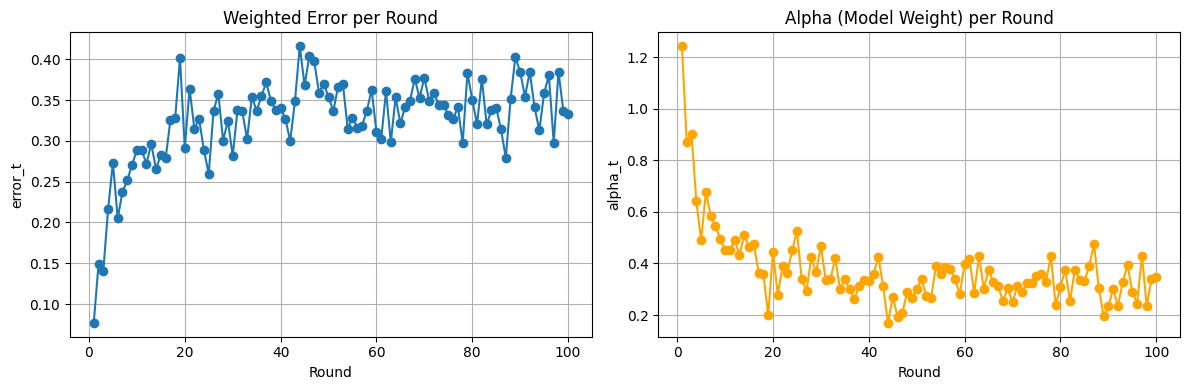

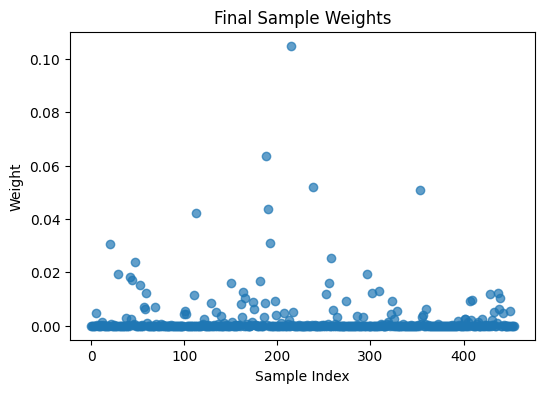

In [11]:
T = 100
learners = []
alphas = []
errors = []
weights_history = []

w = torch.ones(len(X_train), dtype=torch.float32) / len(X_train)

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    y_pred_t = torch.tensor(2*stump.predict(X_train) - 1, dtype=torch.float32)
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float()).item()
    alpha_t = 0.5 * torch.log(torch.tensor((1 - error_t + 1e-10) / (error_t + 1e-10)))
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)

    # ✅ Store for visualization
    errors.append(error_t)
    weights_history.append(w.clone().numpy())

    learners.append(stump)
    alphas.append(alpha_t)

H = torch.zeros(len(X_test))
for alpha_t, stump in zip(alphas, learners):
    y_pred = torch.tensor(2*stump.predict(X_test)-1, dtype=torch.float32)
    H += alpha_t * y_pred
y_final = torch.sign(H)
y_final[y_final==-1] = 0
acc = (y_final.numpy() == y_test).mean()
print(f"T={T}, Manual AdaBoost Accuracy: {acc:.8f}")
plt.figure(figsize=(12,4))

# Weighted error
plt.subplot(1,2,1)
plt.plot(range(1,T+1), errors, marker='o')
plt.title('Weighted Error per Round')
plt.xlabel('Round')
plt.ylabel('error_t')
plt.grid(True)

# Alpha values
plt.subplot(1,2,2)
plt.plot(range(1,T+1), [a.item() for a in alphas], marker='o', color='orange')
plt.title('Alpha (Model Weight) per Round')
plt.xlabel('Round')
plt.ylabel('alpha_t')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot final sample weights
final_weights = weights_history[-1]
plt.figure(figsize=(6,4))
plt.scatter(range(len(final_weights)), final_weights, alpha=0.7)
plt.title('Final Sample Weights')
plt.xlabel('Sample Index')
plt.ylabel('Weight')
plt.show()


T=5, Manual AdaBoost Accuracy: 0.9561


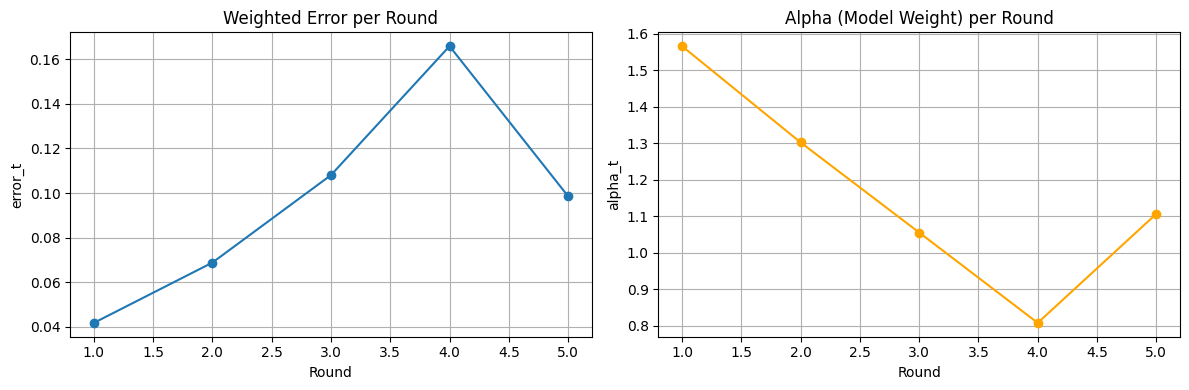

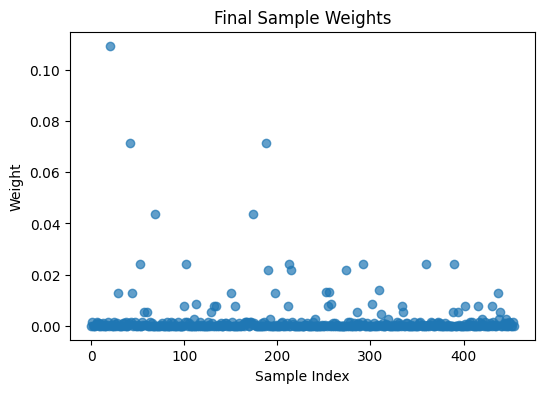

In [12]:
T = 5
learners = []
alphas = []
errors = []
weights_history = []

w = torch.ones(len(X_train), dtype=torch.float32) / len(X_train)

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=2)
    stump.fit(X_train, y_train, sample_weight=w.numpy())

    y_pred_t = torch.tensor(2*stump.predict(X_train) - 1, dtype=torch.float32)
    incorrect = (y_pred_t != y_train_t)
    error_t = torch.sum(w * incorrect.float()).item()
    alpha_t = 0.5 * torch.log(torch.tensor((1 - error_t + 1e-10) / (error_t + 1e-10)))
    w = w * torch.exp(-alpha_t * y_train_t * y_pred_t)
    w = w / torch.sum(w)

    # ✅ Store for visualization
    errors.append(error_t)
    weights_history.append(w.clone().numpy())

    learners.append(stump)
    alphas.append(alpha_t)

H = torch.zeros(len(X_test))
for alpha_t, stump in zip(alphas, learners):
    y_pred = torch.tensor(2*stump.predict(X_test)-1, dtype=torch.float32)
    H += alpha_t * y_pred
y_final = torch.sign(H)
y_final[y_final==-1] = 0
acc = (y_final.numpy() == y_test).mean()
print(f"T={T}, Manual AdaBoost Accuracy: {acc:.4f}")
plt.figure(figsize=(12,4))

# Weighted error
plt.subplot(1,2,1)
plt.plot(range(1,T+1), errors, marker='o')
plt.title('Weighted Error per Round')
plt.xlabel('Round')
plt.ylabel('error_t')
plt.grid(True)

# Alpha values
plt.subplot(1,2,2)
plt.plot(range(1,T+1), [a.item() for a in alphas], marker='o', color='orange')
plt.title('Alpha (Model Weight) per Round')
plt.xlabel('Round')
plt.ylabel('alpha_t')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot final sample weights
final_weights = weights_history[-1]
plt.figure(figsize=(6,4))
plt.scatter(range(len(final_weights)), final_weights, alpha=0.7)
plt.title('Final Sample Weights')
plt.xlabel('Sample Index')
plt.ylabel('Weight')
plt.show()


For T = 5, the weighted error per round increases with every round. The alpha per round decreases every round. The final sample weight tends to be very light with a few outliers. The manual AdaBoost accuracy is 0.9298

For T = 50, the weighted error per round seems to follow a log(x) path, and the alpha per round follows an inverted log(x) path. The sample weight tends to still be relatively low, but there are more outliers that have higher sample weights. The manual AdaBoost accuracy is 0.95614035.

For T = 100, the weighted error has many more points that still follow the same path of log(x), which is the same as T = 50, and the same with the alpha. Though the final sample weight range is a lot bigger than before. The manual AdaBoost accuracy is 0.95614035.

For T = 5, the max depth is 2. The adaboost accuracy is 0.9561. The weighted error reaches its peak at point four, and then it goes down, and the alpha does something similar but in inverse. The sample weight outliers tend to lean more to the left side.

Bagging

Write a script that generates a random sequence of N elements and creates M bootstrap samples from that sequence
can use `random.randint` and `random.choices`.

In [13]:
import random

# Parameters
N = random.randint(5, 100)  # number of elements in the sequence
M = random.randint(5, 100)  # number of bootstrap samples
print("N:", N)
print("M:", M)
#Generate a random sequence of N integers between 1 and 100
sequence = [random.randint(1, 100) for _ in range(N)]
print("Original sequence:", sequence)

# Generate M bootstrap samples
bootstrap_samples = []
for i in range(M):
    sample = random.choices(sequence, k=N)  # sample with replacement
    bootstrap_samples.append(sample)
    print(f"Bootstrap sample {i+1}:", sample)


N: 32
M: 6
Original sequence: [98, 45, 4, 95, 15, 33, 36, 65, 92, 85, 19, 83, 87, 67, 89, 17, 62, 37, 23, 57, 80, 7, 64, 4, 84, 48, 22, 34, 1, 76, 95, 73]
Bootstrap sample 1: [37, 64, 4, 73, 87, 37, 73, 1, 22, 4, 36, 95, 45, 4, 83, 4, 95, 67, 85, 57, 19, 48, 89, 65, 62, 89, 36, 87, 7, 73, 95, 95]
Bootstrap sample 2: [73, 85, 80, 36, 85, 34, 48, 45, 83, 87, 73, 62, 57, 1, 95, 17, 22, 95, 85, 65, 22, 19, 89, 89, 15, 34, 64, 95, 84, 62, 98, 57]
Bootstrap sample 3: [89, 15, 64, 95, 17, 7, 23, 4, 67, 22, 57, 36, 34, 87, 95, 89, 65, 85, 62, 57, 85, 45, 98, 7, 48, 95, 33, 48, 92, 33, 85, 84]
Bootstrap sample 4: [67, 95, 80, 17, 37, 15, 19, 23, 98, 73, 95, 92, 67, 36, 1, 85, 4, 95, 45, 65, 36, 64, 19, 15, 95, 37, 76, 98, 76, 64, 37, 4]
Bootstrap sample 5: [87, 36, 89, 34, 95, 87, 15, 64, 19, 22, 19, 80, 19, 64, 62, 15, 62, 45, 85, 4, 7, 4, 33, 4, 87, 4, 45, 45, 83, 95, 1, 48]
Bootstrap sample 6: [89, 4, 48, 1, 80, 33, 65, 84, 87, 64, 1, 45, 84, 37, 73, 37, 80, 23, 22, 22, 57, 4, 1, 7, 57, 76, 